# Fine-tune SAM on customized datasets (2D example)
1. Prepare original 2D images `data/MedSAMDemo_2D/` (Download link:https://drive.google.com/file/d/18GhVEODbTi17jSeBXdeLQ7vHPdtlTYXK/view?usp=share_link) 
2. Run `pre_grey_rgb2D.py` for pre-processing. Expected output: `./data/demo2D_vit_b/demo2d.npz`
3. Start this fine-tuning tutorial

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [72]:
#%% create a dataset class to load npz data and return back image embeddings and ground truth
class NpzDataset(Dataset): 
    def __init__(self, data_root):
        self.data_root = data_root
        self.npz_files = sorted(os.listdir(self.data_root)) 
        self.npz_data = [np.load(join(data_root, f)) for f in self.npz_files]
        # this implementation is ugly but it works (and is also fast for feeding data to GPU) if your server has enough RAM
        # as an alternative, you can also use a list of npy files and load them one by one
        self.ori_gts = np.vstack([d['gts'] for d in self.npz_data])
        self.img_embeddings = np.vstack([d['img_embeddings'] for d in self.npz_data])
        print(f"{self.img_embeddings.shape=}, {self.ori_gts.shape=}")
    
    def __len__(self):
        return self.ori_gts.shape[0]

    def __getitem__(self, index):
        img_embed = self.img_embeddings[index]
        gt2D = self.ori_gts[index]
        y_indices, x_indices = np.where(gt2D > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = gt2D.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bboxes = np.array([x_min, y_min, x_max, y_max])
        # convert img embedding, mask, bounding box to torch tensor
        return torch.tensor(img_embed).float(), torch.tensor(gt2D[None, :,:]).long(), torch.tensor(bboxes).float()

In [73]:
# %% test dataset class and dataloader
npz_tr_path = 'data/demo2D_vit_b'
demo_dataset = NpzDataset(npz_tr_path)
demo_dataloader = DataLoader(demo_dataset, batch_size=8, shuffle=True)
for img_embed, gt2D, bboxes in demo_dataloader:
    # img_embed: (B, 256, 64, 64), gt2D: (B, 1, 256, 256), bboxes: (B, 4)
    print(f"{img_embed.shape=}, {gt2D.shape=}, {bboxes.shape=}")
    break

self.img_embeddings.shape=(456, 256, 64, 64), self.ori_gts.shape=(456, 256, 256)
img_embed.shape=torch.Size([8, 256, 64, 64]), gt2D.shape=torch.Size([8, 1, 256, 256]), bboxes.shape=torch.Size([8, 4])


In [74]:
# %% set up model for fine-tuning 
# train data path
npz_tr_path = 'data/demo2D_vit_b'
work_dir = './work_dir'
task_name = 'demo2D'
# prepare SAM model
model_type = 'vit_b'
checkpoint = 'work_dir/SAM/sam_vit_b_01ec64.pth'
device = 'cuda:0'
model_save_path = join(work_dir, task_name)
os.makedirs(model_save_path, exist_ok=True) #directory 생성
sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
sam_model.train()
# Set up the optimizer, hyperparameter tuning will improve performance here
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [75]:
#%% train
num_epochs = 100
losses = []
best_loss = 1e10
train_dataset = NpzDataset(npz_tr_path)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
for epoch in range(num_epochs):
    epoch_loss = 0
    # train
    for step, (image_embedding, gt2D, boxes) in enumerate(tqdm(train_dataloader)):
        # do not compute gradients for image encoder and prompt encoder
        with torch.no_grad():
            # convert box to 1024x1024 grid
            box_np = boxes.numpy()
            sam_trans = ResizeLongestSide(sam_model.image_encoder.img_size)
            box = sam_trans.apply_boxes(box_np, (gt2D.shape[-2], gt2D.shape[-1]))
            box_torch = torch.as_tensor(box, dtype=torch.float, device=device)
            if len(box_torch.shape) == 2:
                box_torch = box_torch[:, None, :] # (B, 1, 4)
            # get prompt embeddings 
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )
        # predicted masks
        mask_predictions, _ = sam_model.mask_decoder(
            image_embeddings=image_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          )

        loss = seg_loss(mask_predictions, gt2D.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= step
    losses.append(epoch_loss)
    print(f'EPOCH: {epoch}, Loss: {epoch_loss}')
    # save the latest model checkpoint
    torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_latest.pth'))
    # save the best model
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(sam_model.state_dict(), join(model_save_path, 'sam_model_best.pth'))

self.img_embeddings.shape=(456, 256, 64, 64), self.ori_gts.shape=(456, 256, 256)


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 0, Loss: 0.3099240703242166


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 1, Loss: 0.2061936248626028


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 2, Loss: 0.1828449602637972


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


EPOCH: 3, Loss: 0.15858958129371917


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


EPOCH: 4, Loss: 0.15193046629428864


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


EPOCH: 5, Loss: 0.140888940010752


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


EPOCH: 6, Loss: 0.12542770909411566


100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


EPOCH: 7, Loss: 0.12606855481863022


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 8, Loss: 0.12491249931710106


100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


EPOCH: 9, Loss: 0.11971952446869441


100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


EPOCH: 10, Loss: 0.11403408433709826


KeyboardInterrupt: 

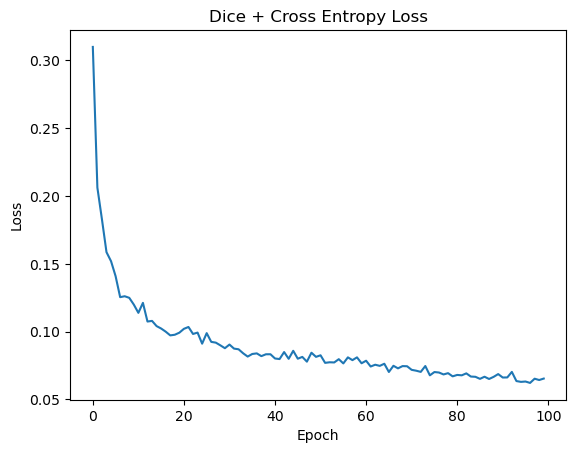

In [ ]:
# plot loss
plt.plot(losses)
plt.title('Dice + Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show() # comment this line if you are running on a server
plt.savefig(join(model_save_path, 'train_loss.png'))
plt.close()

In [ ]:
def get_bbox_from_mask(mask):
    '''Returns a bounding box from a mask'''
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))

    return np.array([x_min, y_min, x_max, y_max])

def extract_digits(string):
    digits = re.findall(r'\d{6}', string)
    if digits:
        first_part = digits[0][:4]
        second_part = digits[0][-2:]
        return first_part, second_part
    else:
        return None, None
    
def extract_same_first_elements(lst):
    result = []
    seen = set()
    for sub_list in lst:
        first_element = sub_list[0]
        if first_element not in seen:
            same_first_elements = [x for x in lst if x[0] == first_element]
            result.append(same_first_elements)
            seen.add(first_element)
    return result

In [ ]:
from skimage import io
ori_sam_model = sam_model_registry[model_type](checkpoint=checkpoint).to(device)
ori_sam_predictor = SamPredictor(ori_sam_model)

test_img_path = 'data/MedSAMDemo_2D/test/images'
test_gt_path = 'data/MedSAMDemo_2D/test/labels'
test_names = sorted(os.listdir(test_img_path))

import re
    
splited_names = []
for name in test_names : 
    splited_names.append(extract_digits(name))

same_first_elements = extract_same_first_elements(splited_names)

[('0004', '00'), ('0004', '01'), ('0004', '02'), ('0004', '03'), ('0004', '04'), ('0004', '05'), ('0004', '06'), ('0004', '07'), ('0004', '08'), ('0004', '09'), ('0004', '10'), ('0004', '11'), ('0004', '12'), ('0004', '13'), ('0004', '14'), ('0004', '15'), ('0007', '00'), ('0007', '01'), ('0007', '02'), ('0007', '03'), ('0007', '04'), ('0007', '05'), ('0007', '06'), ('0007', '07'), ('0007', '08'), ('0007', '09'), ('0007', '10'), ('0023', '00'), ('0023', '01'), ('0023', '02'), ('0023', '03'), ('0023', '04'), ('0023', '05'), ('0024', '00'), ('0024', '01'), ('0024', '02'), ('0024', '03'), ('0024', '04'), ('0024', '05'), ('0024', '06'), ('0024', '07'), ('0024', '08'), ('0024', '09'), ('0026', '00'), ('0026', '01'), ('0026', '02'), ('0026', '03'), ('0026', '04'), ('0029', '00'), ('0029', '01'), ('0029', '02'), ('0029', '03'), ('0029', '04'), ('0029', '05'), ('0029', '06'), ('0029', '07'), ('0029', '08'), ('0029', '09'), ('0029', '10'), ('0029', '11'), ('0029', '12'), ('0029', '13'), ('0029'

In [ ]:
# print(len(splited_names))
# print(len(splited_names[0]))

101
2


In [ ]:
# def extract_same_first_elements(lst):
#     result = []
#     seen = set()
#     for sub_list in lst:
#         first_element = sub_list[0]
#         if first_element not in seen:
#             same_first_elements = [x for x in lst if x[0] == first_element]
#             result.append(same_first_elements)
#             seen.add(first_element)
#     return result

# same_first_elements = extract_same_first_elements(splited_names)

# print(same_first_elements)

[[('0004', '00'), ('0004', '01'), ('0004', '02'), ('0004', '03'), ('0004', '04'), ('0004', '05'), ('0004', '06'), ('0004', '07'), ('0004', '08'), ('0004', '09'), ('0004', '10'), ('0004', '11'), ('0004', '12'), ('0004', '13'), ('0004', '14'), ('0004', '15')], [('0007', '00'), ('0007', '01'), ('0007', '02'), ('0007', '03'), ('0007', '04'), ('0007', '05'), ('0007', '06'), ('0007', '07'), ('0007', '08'), ('0007', '09'), ('0007', '10')], [('0023', '00'), ('0023', '01'), ('0023', '02'), ('0023', '03'), ('0023', '04'), ('0023', '05')], [('0024', '00'), ('0024', '01'), ('0024', '02'), ('0024', '03'), ('0024', '04'), ('0024', '05'), ('0024', '06'), ('0024', '07'), ('0024', '08'), ('0024', '09')], [('0026', '00'), ('0026', '01'), ('0026', '02'), ('0026', '03'), ('0026', '04')], [('0029', '00'), ('0029', '01'), ('0029', '02'), ('0029', '03'), ('0029', '04'), ('0029', '05'), ('0029', '06'), ('0029', '07'), ('0029', '08'), ('0029', '09'), ('0029', '10'), ('0029', '11'), ('0029', '12'), ('0029', '13

In [84]:
# print('전체 묶음 개수 : ', len(same_first_elements))

'''image index 리스트 정렬'''
sum = 0
idx_list = []
idx_list.append(0)
count_list = []
count_list.append(0)
for a in same_first_elements : 
    # print(len(a))
    sum = sum + len(a)
    count_list.append(sum-1)
    
    idx_list.append(sum-1)
    idx_list.append(sum)
    # print(idx_list[-2:])
    if a == same_first_elements[-1] : 
        idx_list.append(sum-1)


# print(idx_list)
idx_list = [idx_list[i:i+2] for i in range(0, len(idx_list), 2)]
# print('총 개수 : ', sum)
print('idx_list : ', idx_list)
print('count_list : ', count_list)

idx_list :  [[0, 15], [16, 26], [27, 32], [33, 42], [43, 47], [48, 67], [68, 76], [77, 90], [91, 91], [92, 100], [101, 100]]
count_list :  [0, 15, 26, 32, 42, 47, 67, 76, 90, 91, 100]


In [102]:

'''
original SAM 모델추론. 
첫 데이터의 bbox 는 gt_data에서 bbox를 random 하게 얻기 . 
'''
global ori_sam_seg

def original_inference(img_idx, image_data, test_gt_path = test_gt_path) : 
    global ori_sam_seg

    gt_data = io.imread(join(test_gt_path, test_names[img_idx]))

    if img_idx in count_list : 
        bbox_raw = get_bbox_from_mask(gt_data)
    else : 
        bbox_raw = get_bbox_from_mask(ori_sam_seg)
    # preprocess: cut-off and max-min normalization
    lower_bound, upper_bound = np.percentile(image_data, 0.5), np.percentile(image_data, 99.5)
    image_data_pre = np.clip(image_data, lower_bound, upper_bound)
    image_data_pre = (image_data_pre - np.min(image_data_pre))/(np.max(image_data_pre)-np.min(image_data_pre))*255.0
    image_data_pre[image_data==0] = 0
    image_data_pre = np.uint8(image_data_pre)
    H, W, _ = image_data_pre.shape

    # predict the segmentation mask using the original SAM model
    ori_sam_predictor.set_image(image_data_pre)
    ori_sam_seg, _, _ = ori_sam_predictor.predict(point_coords=None, box=bbox_raw, multimask_output=False)
    ori_sam_seg = ori_sam_seg.reshape((256, 256)).astype(np.uint8)
    return ori_sam_seg, image_data_pre

In [103]:
a = np.zeros((256,256)).astype(np.uint8)
print(a)
print(np.max(a), np.min(a))



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
0 0


In [104]:
'''
MedSAM으로 inference 수행하기 
'''

global medsam_seg
def medsam_inference(image_data_pre, img_idx, test_gt_path = test_gt_path) : 
    global medsam_seg
    
    # predict the segmentation mask using the fine-tuned model
    # resize image to 3*1024*1024
    sam_transform = ResizeLongestSide(sam_model.image_encoder.img_size)
    resize_img = sam_transform.apply_image(image_data_pre)
    resize_img_tensor = torch.as_tensor(resize_img.transpose(2, 0, 1)).to(device)
    input_image = sam_model.preprocess(resize_img_tensor[None,:,:,:]) # (1, 3, 1024, 1024)
    assert input_image.shape == (1, 3, sam_model.image_encoder.img_size, sam_model.image_encoder.img_size), 'input image should be resized to 1024*1024'

    #get bbox
    gt_data = io.imread(join(test_gt_path, test_names[img_idx]))

    if img_idx in count_list : 
        bbox_raw = get_bbox_from_mask(gt_data)
    else : 
        bbox_raw = get_bbox_from_mask(medsam_seg)

    with torch.no_grad():
        # pre-compute the image embedding
        ts_img_embedding = sam_model.image_encoder(input_image)
        # convert box to 1024x1024 grid
        bbox = sam_trans.apply_boxes(bbox_raw, (H, W))
        print(f'{bbox_raw=} -> {bbox=}')
        box_torch = torch.as_tensor(bbox, dtype=torch.float, device=device)
        if len(box_torch.shape) == 2:
            box_torch = box_torch[:, None, :] # (B, 4) -> (B, 1, 4)
        
        sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
            points=None,
            boxes=box_torch,
            masks=None,
        )
        medsam_seg_prob, _ = sam_model.mask_decoder(
            image_embeddings=ts_img_embedding.to(device), # (B, 256, 64, 64)
            image_pe=sam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
            )
        medsam_seg_prob = torch.sigmoid(medsam_seg_prob)
        # convert soft mask to hard mask
        medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
        medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
    
    return medsam_seg
    # print(medsam_seg.shape)

In [105]:
img_idx = 0
image_data = io.imread(join(test_img_path, test_names[img_idx]))

if image_data.shape[-1]>3 and len(image_data.shape)==3:
    image_data = image_data[:,:,:3]
if len(image_data.shape)==2:
    image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
        
ori_sam_seg, image_data_pre = original_inference(img_idx, image_data)

In [108]:
'''
image idx 선택 후 preprocess
'''


for start, end in idx_list : 
    for i in range(start, end+1) :       
        img_idx = i
        image_data = io.imread(join(test_img_path, test_names[img_idx]))

        if image_data.shape[-1]>3 and len(image_data.shape)==3:
            image_data = image_data[:,:,:3]
        if len(image_data.shape)==2:
            image_data = np.repeat(image_data[:,:,None], 3, axis=-1)
        
        ori_sam_seg, image_data_pre = original_inference(img_idx, image_data)
        medsam_seg = medsam_inference(image_data_pre, img_idx)

        gt_data = io.imread(join(test_gt_path, test_names[img_idx]))
        ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
        medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
        print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))
        

bbox_raw=array([143, 170, 182, 209]) -> bbox=array([[572, 680, 728, 836]])
Original SAM DSC: 0.5096 MedSAM DSC: 0.7454
bbox_raw=array([145, 155, 196, 198]) -> bbox=array([[580, 620, 784, 792]])
Original SAM DSC: 0.1875 MedSAM DSC: 0.7660
bbox_raw=array([158, 154, 185, 208]) -> bbox=array([[632, 616, 740, 832]])
Original SAM DSC: 0.0513 MedSAM DSC: 0.6357
bbox_raw=array([157, 147, 183, 192]) -> bbox=array([[628, 588, 732, 768]])
Original SAM DSC: 0.5554 MedSAM DSC: 0.6397
bbox_raw=array([142, 139, 194, 196]) -> bbox=array([[568, 556, 776, 784]])
Original SAM DSC: 0.6341 MedSAM DSC: 0.9243
bbox_raw=array([132, 120, 191, 206]) -> bbox=array([[528, 480, 764, 824]])
Original SAM DSC: 0.7684 MedSAM DSC: 0.9442
bbox_raw=array([137, 117, 182, 199]) -> bbox=array([[548, 468, 728, 796]])
Original SAM DSC: 0.9181 MedSAM DSC: 0.9640
bbox_raw=array([132, 124, 195, 198]) -> bbox=array([[528, 496, 780, 792]])
Original SAM DSC: 0.9079 MedSAM DSC: 0.9717
bbox_raw=array([135, 132, 194, 211]) -> bbox=arr

In [77]:
# ori_sam_dsc = compute_dice_coefficient(gt_data>0, ori_sam_seg>0)
# medsam_dsc = compute_dice_coefficient(gt_data>0, medsam_seg>0)
# print('Original SAM DSC: {:.4f}'.format(ori_sam_dsc), 'MedSAM DSC: {:.4f}'.format(medsam_dsc))

Original SAM DSC: 0.5849 MedSAM DSC: 0.7500


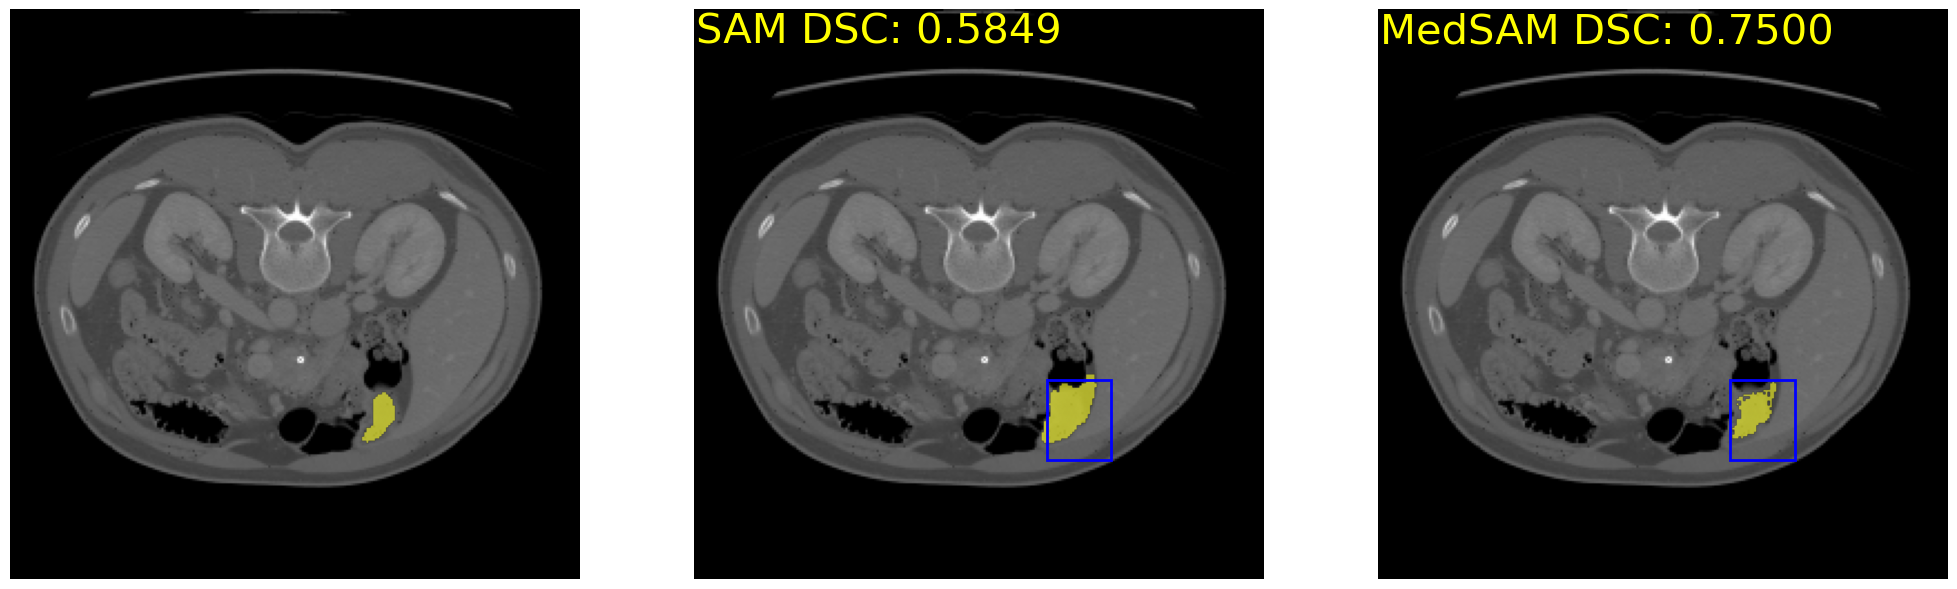

In [69]:
#%% visualize the segmentation results of the middle slice
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))    

_, axs = plt.subplots(1, 3, figsize=(25, 25))
axs[0].imshow(image_data)
show_mask(gt_data>0, axs[0])
# show_box(box_np[img_id], axs[0])
# axs[0].set_title('Mask with Tuned Model', fontsize=20)
axs[0].axis('off')

axs[1].imshow(image_data)
show_mask(ori_sam_seg, axs[1])
show_box(bbox_raw, axs[1])
# add text to image to show dice score
axs[1].text(0.5, 0.5, 'SAM DSC: {:.4f}'.format(ori_sam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[1].set_title('Mask with Untuned Model', fontsize=20)
axs[1].axis('off')

axs[2].imshow(image_data)
show_mask(medsam_seg, axs[2])
show_box(bbox_raw, axs[2])
# add text to image to show dice score
axs[2].text(0.5, 0.5, 'MedSAM DSC: {:.4f}'.format(medsam_dsc), fontsize=30, horizontalalignment='left', verticalalignment='top', color='yellow')
# axs[2].set_title('Ground Truth', fontsize=20)
axs[2].axis('off')
plt.show()  
plt.subplots_adjust(wspace=0.01, hspace=0)
# save plot
# plt.savefig(join(model_save_path, test_npzs[npz_idx].split('.npz')[0] + str(img_id).zfill(3) + '.png'), bbox_inches='tight', dpi=300)
plt.close()

In [70]:
bbox_new = get_bbox_from_mask(medsam_seg)
print(bbox_new)
bbox_new_sam = get_bbox_from_mask(ori_sam_seg.reshape((256,256)).astype(np.uint8))
print(bbox_new_sam)

[149 157 193 195]
[156 160 186 203]
